# Data Scientist Associate Practical Exam

## Company Background
GoalZone is a fitness club chain providing five types of fitness classes in Canada. Finally, the fitness classes schedule is back to normal after the COVID-19 restrictions are lifted. However, they have received many complaints from the customers about having a hard time booking a fitness class.

From initial analysis, the program operation team found out that the fitness classes are always fully booked but are having a low attendance rate per class. To improve this situation, they would like to increase the class capacity for customers to sign up if a low attendance rate is predicted.  


## Customer Question
The operation manager has asked you to answer the following:
- Can you predict the attendance rate for each fitness class? 



## Dataset
The dataset contains the attendance information for the class scheduled this year so far. The data you will use for this analysis can be accessed here: `"data/fitness_class.csv"`

| Column Name                     | Criteria                                                                                                                                                                        |
|---------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Day of Week                     | Character, the day of the week the class was scheduled, one of values from “Mon” to “Sun”.                                                                                      |
| Time                            | Character, the time of the day the class was scheduled, either "AM" or "PM".                                                                                                        |
| Class Category                  | Character, the category of the fitness class, one of “Yoga”, “Aqua”, “Strength”, “HIIT”, or “Cycling”.                                                                          |
| Days Before                     | Numeric, number of days the class stayed fully booked, maximum five days.                                                                                                       |
| Class Capacity                  | Numeric, maximum number of members can sign up for that class, either 15 or 25.  The class capacity being 26 needs to be updated to 25.                                         |
| Attendance                      | Numeric, number of members actually attended the class.                                                                                                                         |
| Average Age                     | Numeric, average age of the members signing up for that class.  Remove rows that average age is smaller than 14 because group fitness class are for members aged 14 and order.  |
| Number of New Students          | Numeric, number of new students signing up for this class.                                                                                                                      |
| Number of Members Over 6 months | Numeric, number of members signing up for the class have been joining the club more than 6 months.                                                                              |                                                                                     |

In [20]:
# Data Validation
# Check all variables in the data against the criteria in the dataset above
# Data imports
import pandas as pd
import numpy as np

# Visualization imports
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
plt.rcParams['figure.figsize'] = [8, 4]


# ML Imports
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression


df = pd.read_csv('data/fitness_class.csv')

print(df.head())
print(df.dtypes)
df.drop([55, 104, 165], inplace=True)
df['class_capacity'] = df['class_capacity'].replace(to_replace=26, value=25, inplace=True)
print(df[df['class_capacity'] == 26])
print(df[df['days_before'] > 5])
print(df['time'].unique())
print(df['class_category'].unique())
print(df['day_of_week'].unique())

df['class_capacity'].fillna(15, inplace=True)
print(df.isna().sum())


  day_of_week time class_category  class_capacity  days_before  attendance  \
0         Wed   AM           Yoga              15            1           8   
1         Sun   PM           Aqua              15            3           8   
2         Mon   AM           Aqua              15            5          10   
3         Sun   PM       Strength              25            3          18   
4         Mon   AM           Yoga              15            5          10   

    age  new_students  over_6_month  
0  31.1             6             4  
1  27.0             7             8  
2  22.4             8             7  
3  23.5             7             9  
4  29.8             5             7  
day_of_week        object
time               object
class_category     object
class_capacity      int64
days_before         int64
attendance          int64
age               float64
new_students        int64
over_6_month        int64
dtype: object
Empty DataFrame
Columns: [day_of_week, time, class_cate

## Data Validation
Describe the validation tasks you completed and what you found. Have you made any changes to the data to enable further analysis? Remember to describe what you did for every column in the data. 

First of all I checked the data types of the columns and checkhed the head of the dataset. I dropped rows where age value was lesser than 14. Then I replaced value of 26 in class capacity column with value of 25. After that, I checked days_before column that if it matches with the description. And then I checked the unique values in columns to make sure values are as inteded with the description. I also filled null values in class_capacity column with 15.

In [5]:
df.head()
df.drop(['day_of_week', 'time', 'class_category'], axis=1)

,class_capacity,days_before,attendance,age,new_students,over_6_month
0,15,1,8,31.1,6,4
1,15,3,8,27.0,7,8
2,15,5,10,22.4,8,7
3,15,3,18,23.5,7,9
4,15,5,10,29.8,5,7
...,...,...,...,...,...,...
760,15,1,4,38.5,5,6
761,15,1,4,41.2,6,3
762,15,4,12,26.1,8,9
763,15,1,7,33.3,5,7


       class_capacity  days_before  attendance         age  new_students  \
count           762.0   762.000000  762.000000  762.000000    762.000000   
mean             15.0     2.547244    9.519685   29.163648      5.912073   
std               0.0     1.355768    3.841164    5.812547      1.788821   
min              15.0     1.000000    4.000000   14.000000      1.000000   
25%              15.0     1.000000    7.000000   25.300000      5.000000   
50%              15.0     2.000000    9.000000   29.000000      6.000000   
75%              15.0     4.000000   11.000000   33.200000      7.000000   
max              15.0     5.000000   21.000000   48.800000     11.000000   

       over_6_month  
count    762.000000  
mean       7.565617  
std        1.968617  
min        2.000000  
25%        6.000000  
50%        8.000000  
75%        9.000000  
max       13.000000  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 762 entries, 0 to 764
Data columns (total 9 columns):
 #   Column  

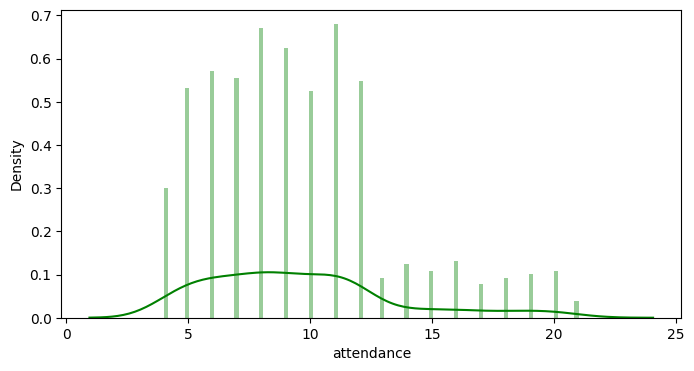

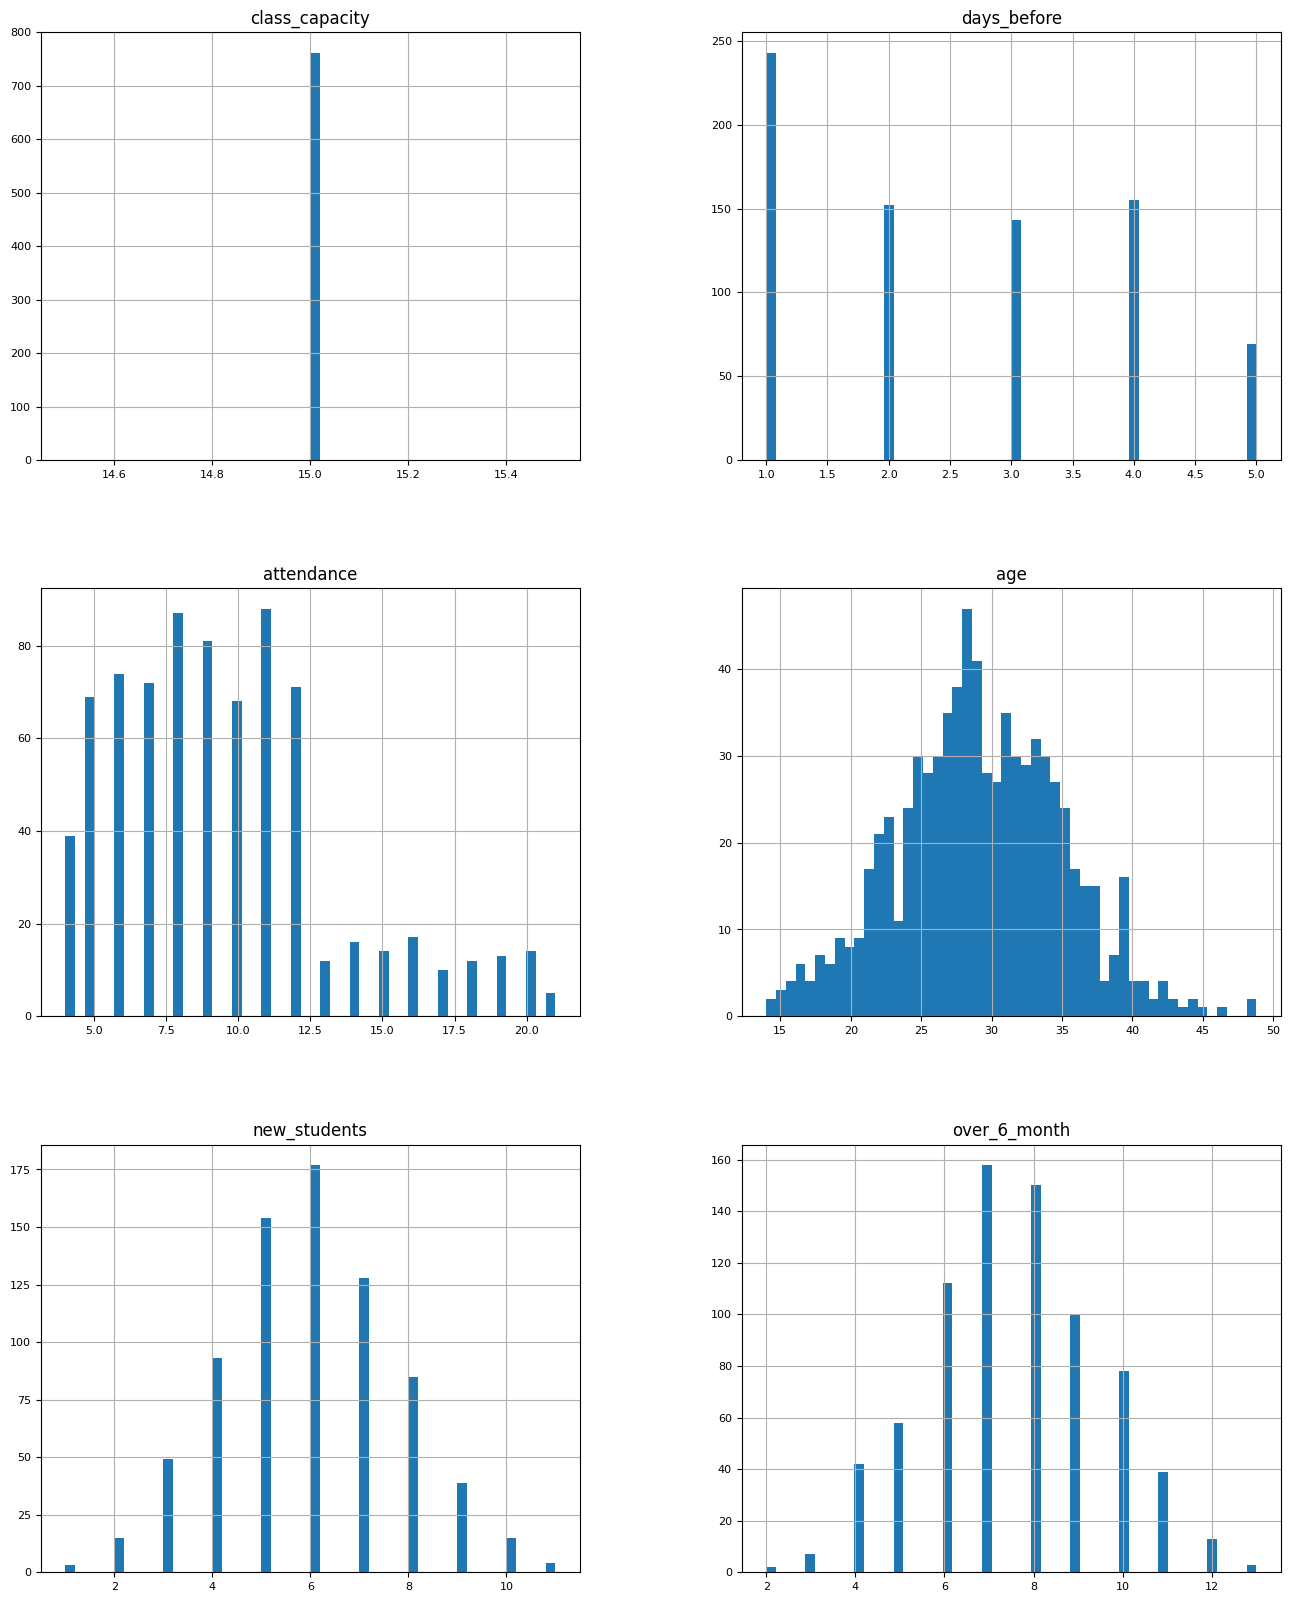

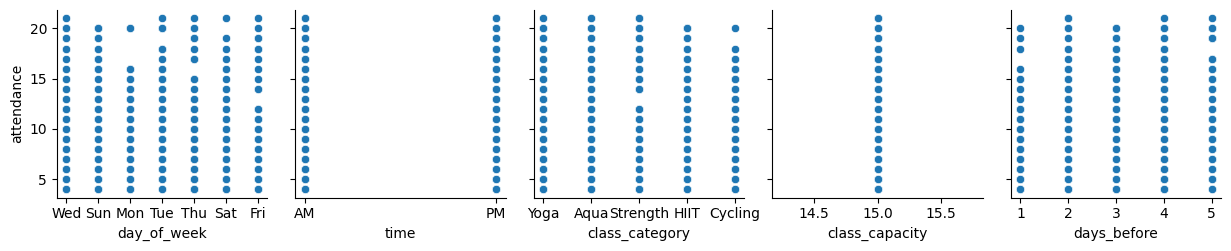

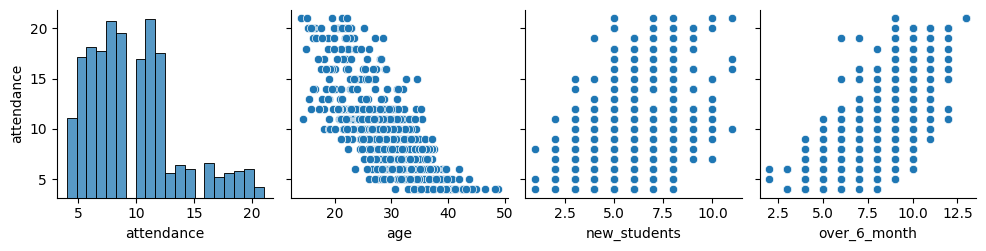

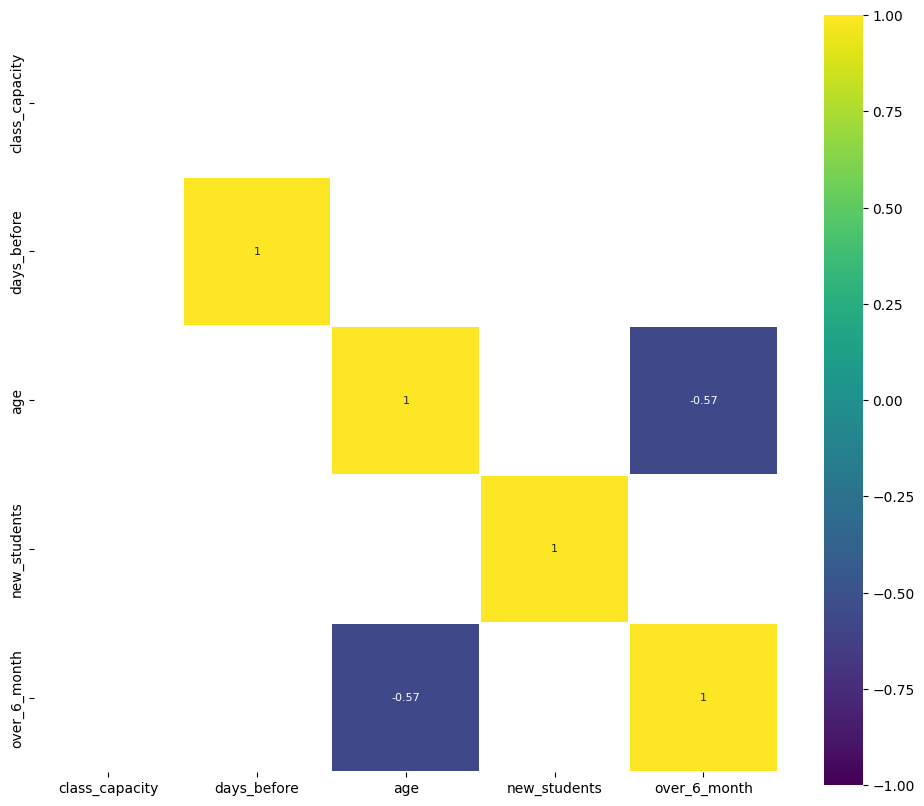

In [86]:
# Exploratory Analysis
# Explore the characteristics of the variables in the data
print(df.describe())
print(df.info())

sns.distplot(df['attendance'], color='g', bins=100, hist_kws={'alpha': 0.4})
df_num = df.select_dtypes(include = ['float64', 'int64', 'uint8', 'object'])
df_num.head()
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)



df_num_corr = df_num.corr()['attendance']
golden_features_list = df_num_corr[abs(df_num_corr) > 0.5].sort_values(ascending=False)
print("There is {} strongly correlated values with attendance:\n{}".format(len(golden_features_list), golden_features_list))

for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['attendance'])

    
corr = df_num.drop('attendance', axis=1).corr() 
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);



In [75]:
print(df_num.head())
X=df_num.drop("attendance", axis=1).values
y=df_num['attendance'].values
over_6_month = X[:, 4]

z = over_6_month.reshape(-1, 1)



   class_capacity  days_before  attendance   age  new_students  over_6_month
0              15            1           8  31.1             6             4
1              15            3           8  27.0             7             8
2              15            5          10  22.4             8             7
3              15            3          18  23.5             7             9
4              15            5          10  29.8             5             7
[[31.1]
 [27. ]
 [22.4]
 [23.5]
 [29.8]
 [28.7]
 [32.5]
 [36. ]
 [15.3]
 [31.3]
 [23.8]
 [30.3]
 [29.2]
 [21.8]
 [34.7]
 [34.4]
 [30.9]
 [38.9]
 [18.7]
 [28.7]
 [32.8]
 [29.7]
 [30.6]
 [30. ]
 [34. ]
 [32.3]
 [31.6]
 [32. ]
 [24.5]
 [24.6]
 [34.1]
 [21.6]
 [33.8]
 [27.2]
 [17.7]
 [33. ]
 [24.7]
 [40.2]
 [23.1]
 [35.2]
 [27.3]
 [25.8]
 [14.8]
 [33.5]
 [31.9]
 [21. ]
 [16.4]
 [16.4]
 [27.8]
 [29.2]
 [26.6]
 [31.7]
 [31.1]
 [39.1]
 [24.6]
 [28.1]
 [26.2]
 [19.9]
 [28.6]
 [30.8]
 [24.5]
 [23. ]
 [31.8]
 [32.2]
 [37.3]
 [23.5]
 [34.2]
 [

## Exploratory Analysis
Describe what you found in the exploratory analysis. In your description you should:
- Reference at least two different data visualizations you created above to demonstrate the characteristics of single variables
- Reference at least one data visualization you created above to demonstrate the relationship between two or more variables
- Describe what your exploratory analysis has told you about the data
- Describe any changes you have made to the data to enable modeling

*Write your description here*

We can see that age, over 6 month and new student variables follow normal distribution. While attendance variable follows a right skewed, positive skewed distribution. For this, please refer to the second section of visualizations.

Also, as the age of participants increase, attendance decreases. And as the number of members who are members for more than 6 month increases, attendance increase aswell. For this, please refer to the third section of visualizations. 

My explarotary analysis helped me to create hypothesis about postive or negative correlations between models. 

I have reshaped the "over_6_month" variable in order to use it for my machine learning models.



Predictions: [ 8.86225174 11.46514707], Actual Values: [ 4 10]


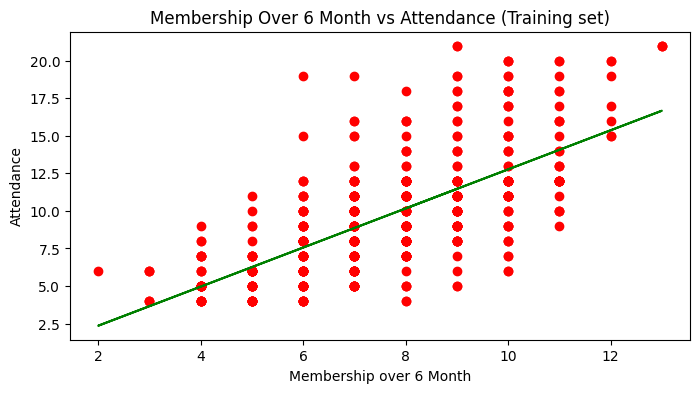

In [53]:
# Model Fitting
# Baseline Model for Over 6 Months


X_train, X_test, y_train, y_test = train_test_split(z, y, test_size=0.3, random_state = 42 )
reg_all=LinearRegression()
reg_all.fit(X_train, y_train)
y_pred=reg_all.predict(X_test)
print("Predictions: {}, Actual Values: {}".format(y_pred[:2], y_test[:2]))

plt.scatter(X_train[:,0], y_train, color = "red")
plt.plot(X_train[:,0], reg_all.predict(X_train), color = "green")
plt.title("Membership Over 6 Month vs Attendance (Training set)")
plt.ylabel('Attendance')
plt.xlabel('Membership over 6 Month')
plt.show()


In [81]:
# Model Fitting
# Comparision Model - Decision Tree for Regression Problem Membership over 6 Month

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

X_train, X_test, y_train, y_test = train_test_split(z, y, test_size= 0.3, random_state=3)

dt= DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.1, random_state=3)

dt.fit(X_train, y_train)
y_pred=dt.predict(X_test)

mse_dt=MSE(y_test, y_pred)
rmse_dt= mse_dt**(1/2)

print("Test set RMSE of dt: {:.2f}".format(rmse_dt))



Test set RMSE of dt: 2.55


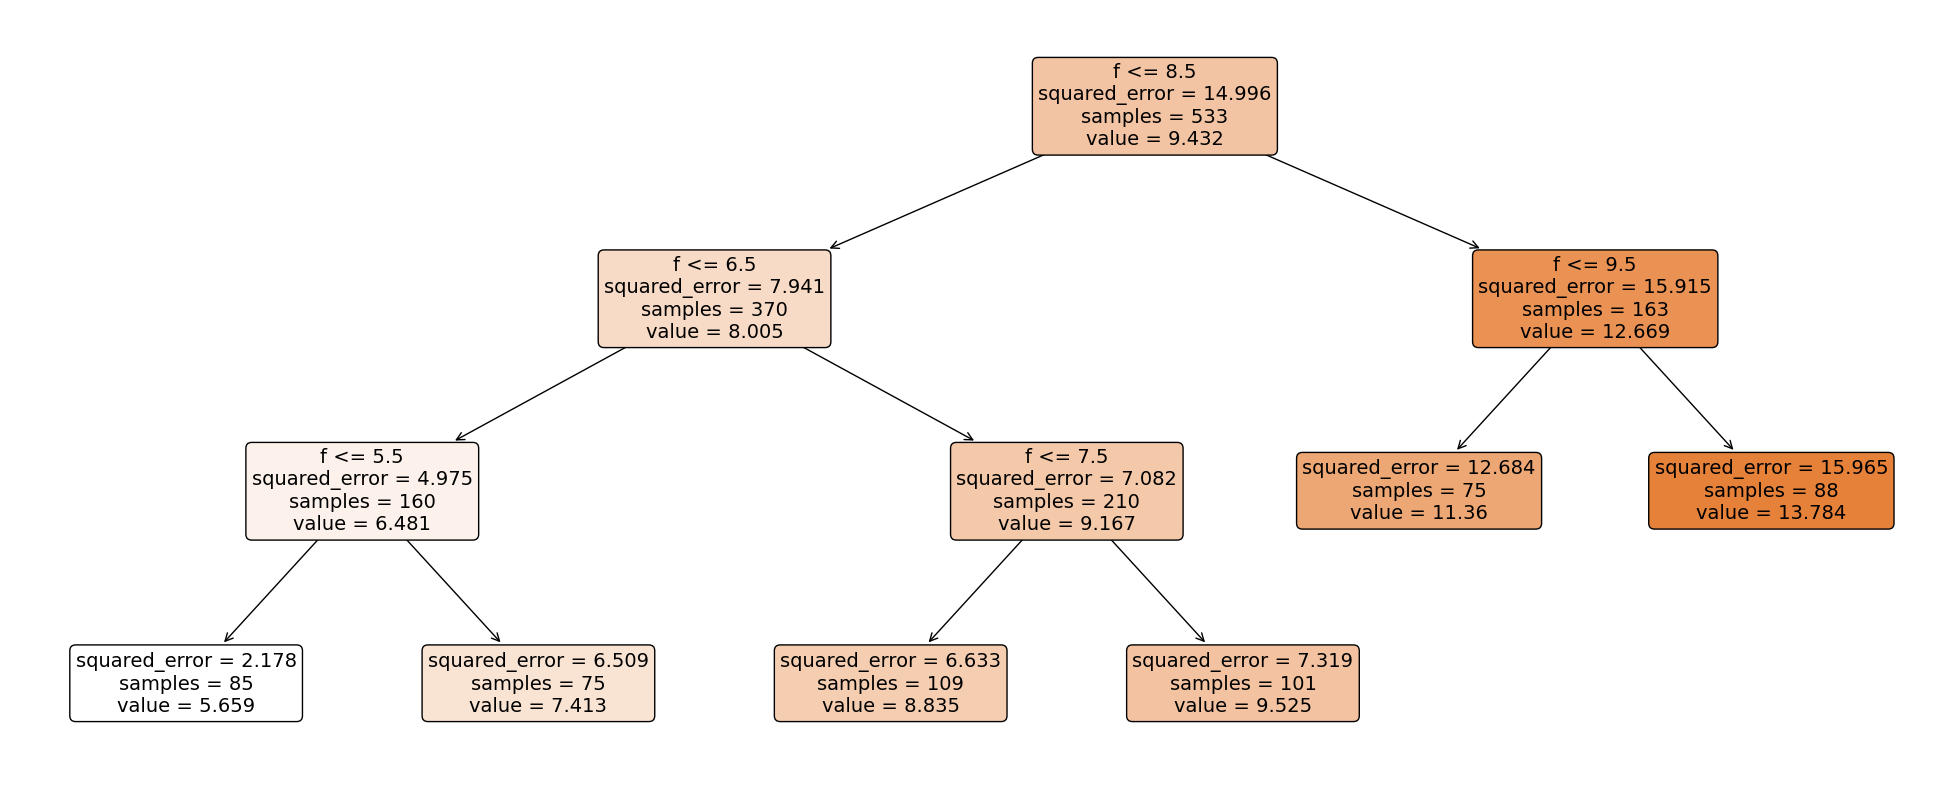

In [82]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
plt.figure(figsize=(25,10))
a = plot_tree(dt, 
              feature_names="feature", 
              class_names="target", 
              filled=True, 
              rounded=True, 
              fontsize=14)

## Model Fitting
Describe your approach to the model fitting. In your description you should:
- Describe what type of machine learning problem you are working on
- Describe which method you selected for the baseline model and explain why you chose this model
- Describe which method you selected for the comparison model and explain why you chose this model

*Write your description here*

Main problem here is predicting the future of attendance rates. So the machine learning problem here is prediction or predictive analytics. Predictive analytics is a branch of advanced analytics that makes predictions about future outcomes using historical data combined with statistical modeling, data mining techniques and machine learning.

With predictive analytics, I'll need to predict the attendance variable which is my target variable. The target variable is the variable whose values are modeled and predicted by other variables. My target variable in this case study is attendence. Attendance is a contunious variable therefore I'll be using the supervised technique called regression instead of classification as my variable is not a categorical variable.

Variables that have high correlation with attendance variable could perform better in regression models. The "over_6_month" variable has high positive correlation meanwhile "age" variable has high negative correlation.

So I used these two variables with linear regression first as linear regression is one of the simplest ways to do regression provided the variables in question has high correlation. And with visualization it is also intiutive to see the predictions.

Then I used Decision Tree Regressor as my comparison model since it is a more "advanced" regression model for regression problems. Compared to other algorithms decision trees requires less effort for data preparation during pre-processing. A Decision tree model is very intuitive and easy to explain.

The reason why I didnt use age as a variable is that, even though negative correlations are as useful as the positive ones, they performed poorly with regression trees so I've decided to stick with the over the 6 month variable.

Finally, I can say that this fitness club should focus on retaining new young members as the members who seem to be members for more than 6 months attends classes better and as the age increases, attendance decreases so focus should be on the young members.

Except monday, there is no significant difference between days of attendance nor there is a significant difference between AM or PM. Same goes for class categories aswell.




In [62]:
# Model Evaluation
# Choose a metric and evaluate the performance of the two models

y_pred_reg_all = reg_all.predict(X_test)

# Compute mse_lr
mse_reg_all = MSE(y_test, y_pred_reg_all)

# Compute rmse_lr
rmse_reg_all = mse_reg_all**(1/2)

# Print rmse_lr
print('Linear Regression test set RMSE: {:.2f}'.format(rmse_reg_all))

# Print rmse_dt
print('Regression Tree test set RMSE: {:.2f}'.format(rmse_dt))

Linear Regression test set RMSE: 2.58
Regression Tree test set RMSE: 2.55


## Model Evaluation
Explain what the results of your evaluation tell you. You should:
- Describe which metric you have selected to compare the models and why
- Explain what the outcome of this evaluation tells you about the performance of your models
- Identify, based on the evaluation, which you would consider to be the better performing approach

*Write your description here*

I've used root mean squared error as the metric to compare the models. In machine learning, it is extremely helpful to have a single number to judge a model’s performance, whether it be during training, cross-validation, or monitoring after deployment. Root mean square error is one of the most widely used measures for this. It is a proper scoring rule that is intuitive to understand and compatible with some of the most common statistical assumptions.

RMSE's of Regression Tree and Linear Regression model is fairly similiar. Though Regression Tree seems to be performing slightly better. Linear Regression's RMSE is 2.58 while Regression Tree's RMSE is 2.55. 

Based on this evaluation I would consider Regression Tree is the better performing approach.



## ✅ When you have finished...
- Publish your Workspace using the option on the left
- Check the published version of your report:
	- Can you see everything you want us to grade?
    - Are all the graphics visible?
- Review grading rubric. Have you included everything that will be graded?
- Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam